In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic
from scipy.optimize import minimize

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
# def age_model(x1,x2,x3):  
#     #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
#     p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
#          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
#     age = (p[0]+p[1]*x1+p[2]*x2+p[3]*x3+
#            p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
#            p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
#            p[10]*(x2**3)+p[11]*(x3**3))
    
#     return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [3]:
### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

# linAge: 0.5e9 - 7.0e9, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
young_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_0.5_7.0.dat',format='basic',
                          delimiter='\s')
# linAge: 7.5e9 - 1.4e10, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
old_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_7.5_14.0.dat',format='basic',
                          delimiter='\s')

parsec = vstack([young_parsec,old_parsec])

rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

In [4]:
parsec.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

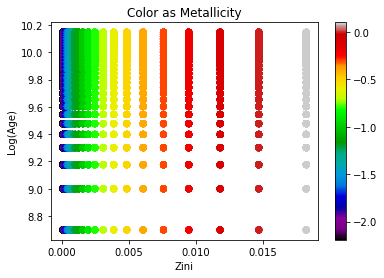

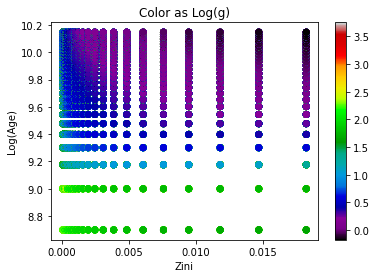

----------


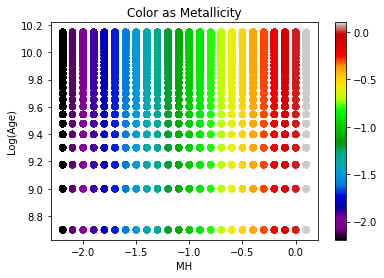

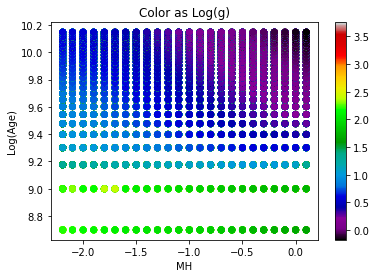

----------


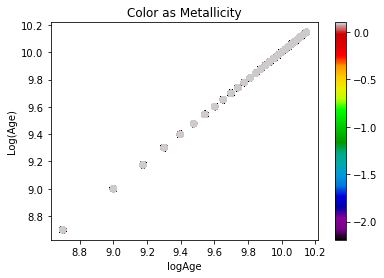

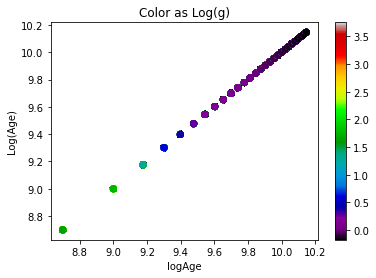

----------


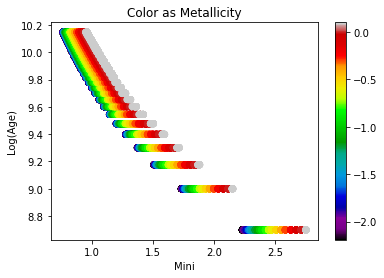

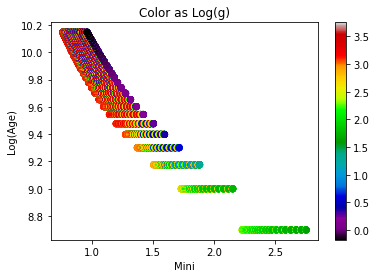

----------


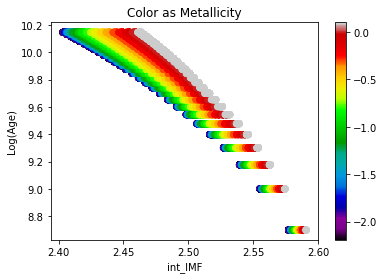

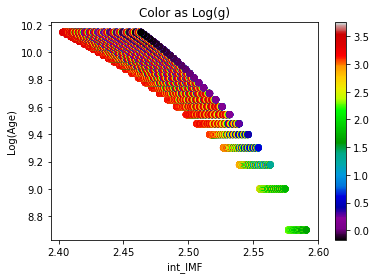

----------


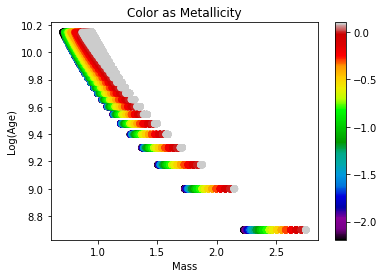

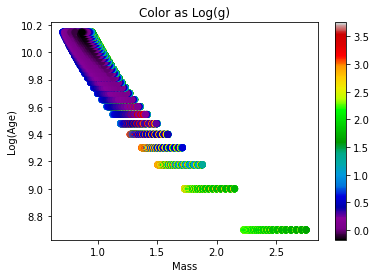

----------


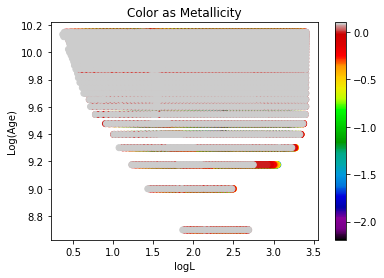

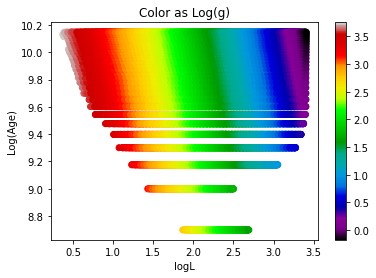

----------


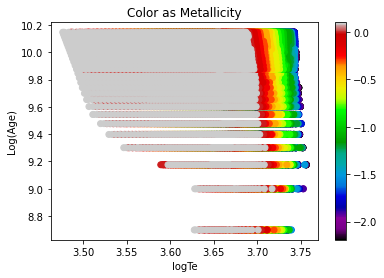

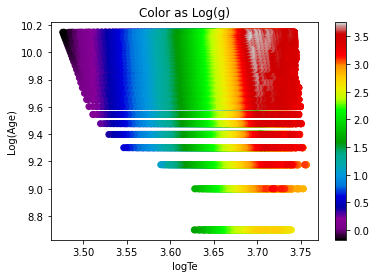

----------


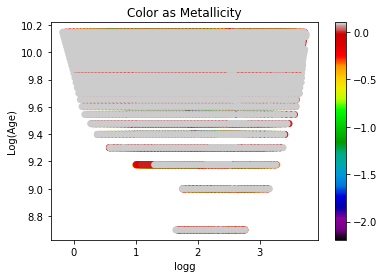

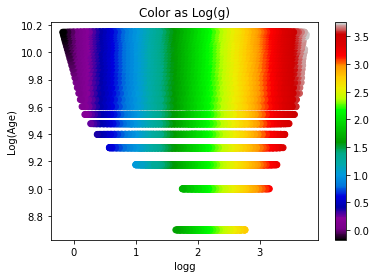

----------


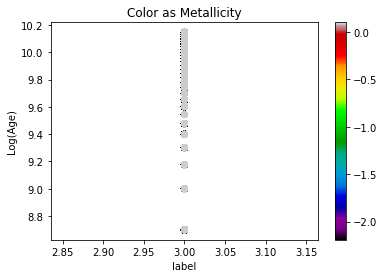

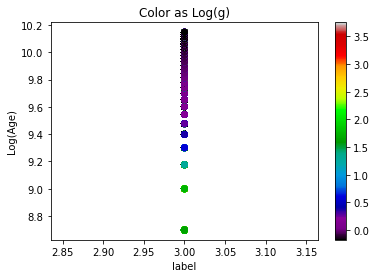

----------


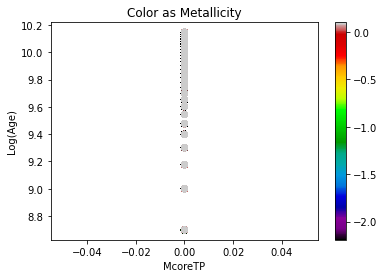

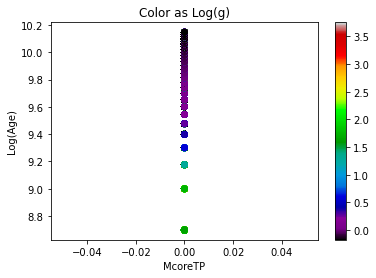

----------


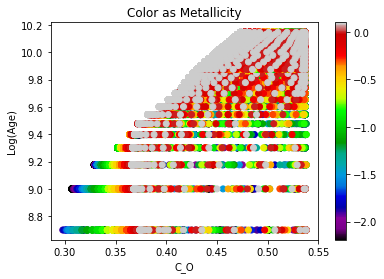

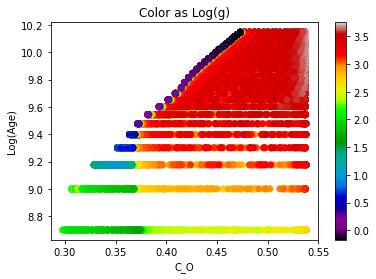

----------


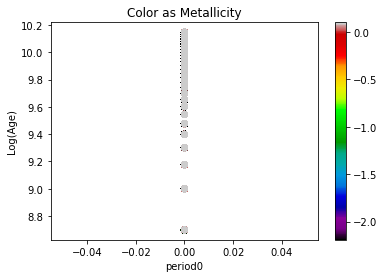

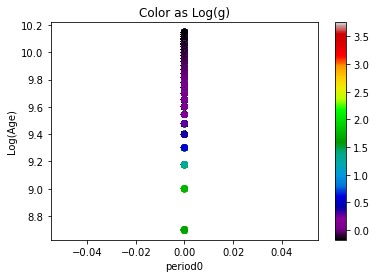

----------


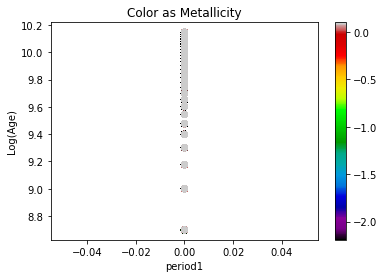

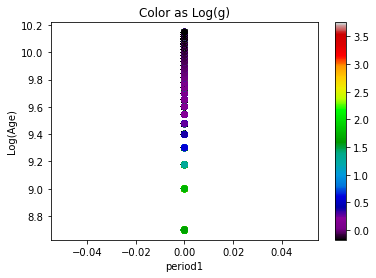

----------


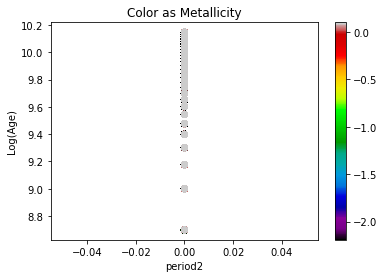

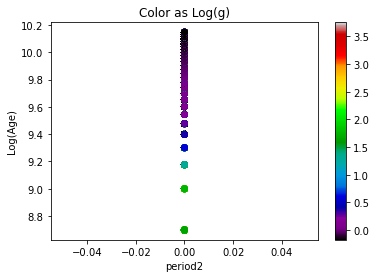

----------


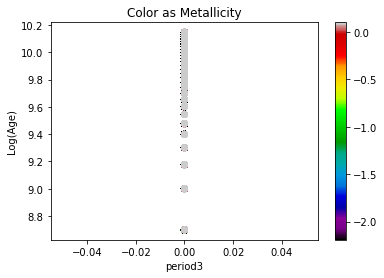

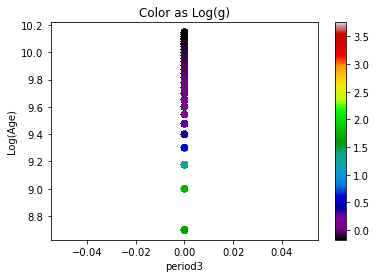

----------


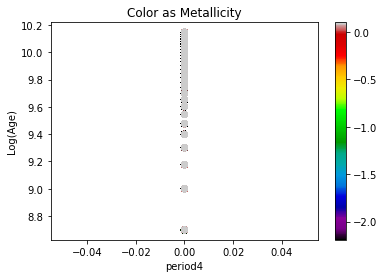

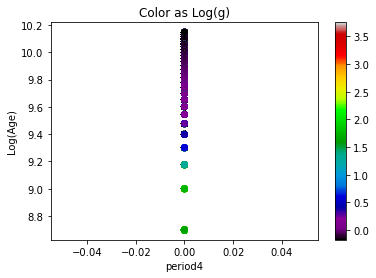

----------


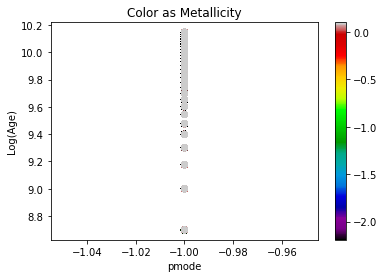

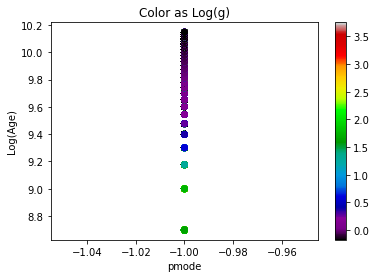

----------


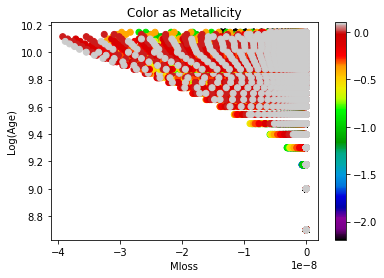

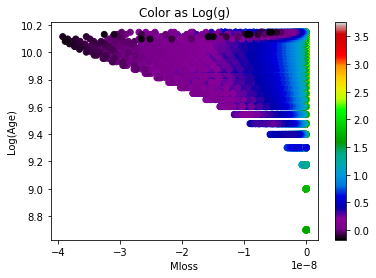

----------


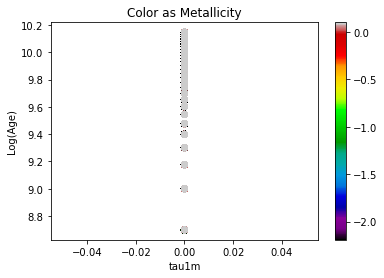

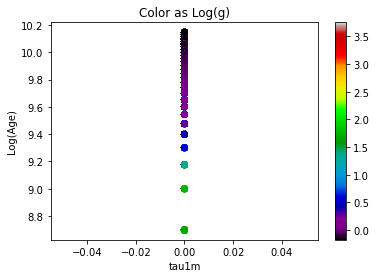

----------


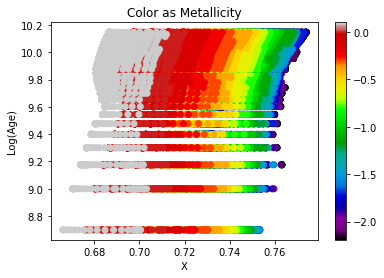

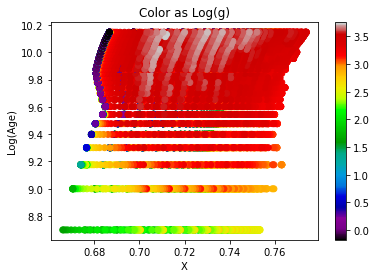

----------


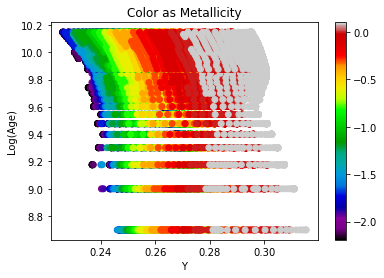

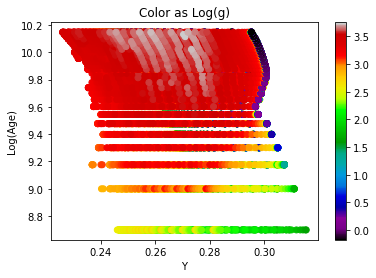

----------


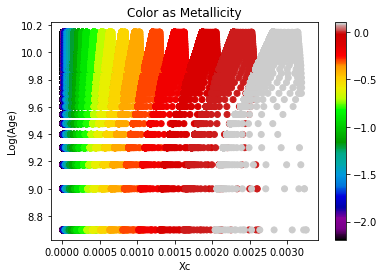

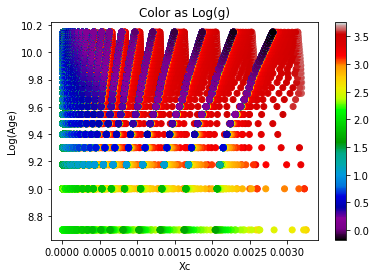

----------


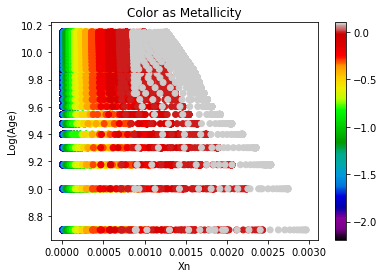

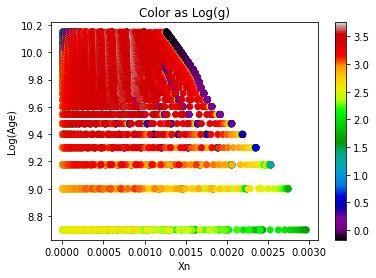

----------


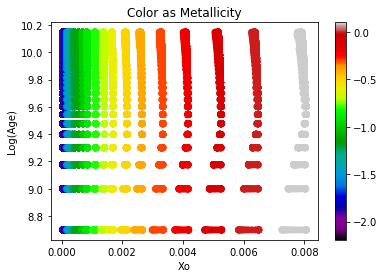

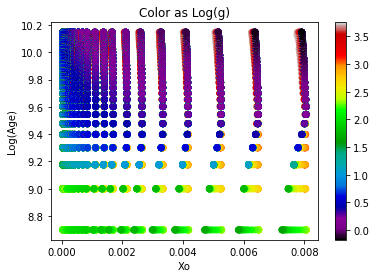

----------


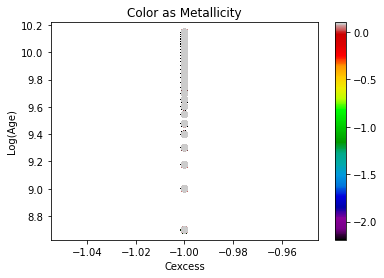

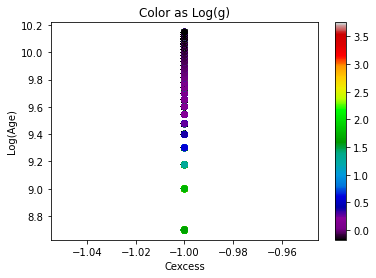

----------


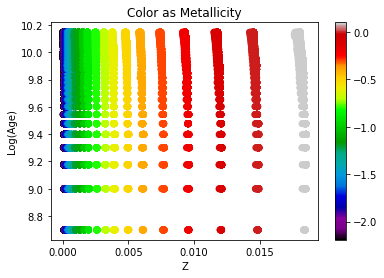

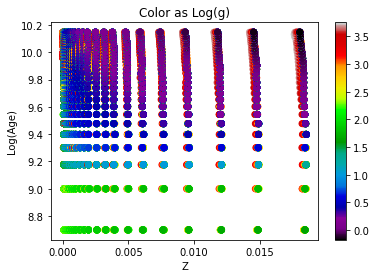

----------


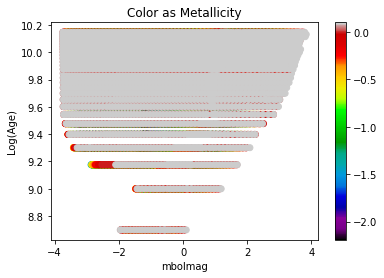

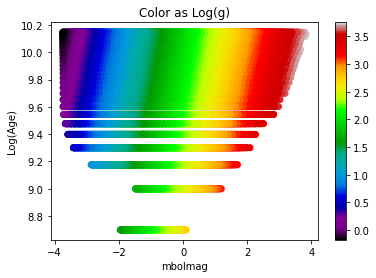

----------


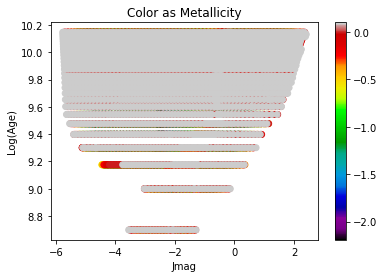

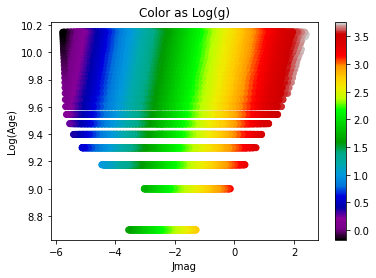

----------


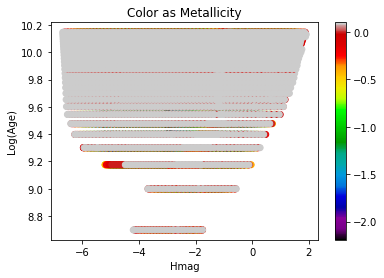

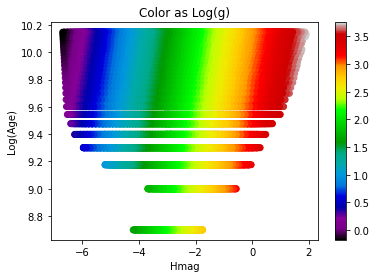

----------


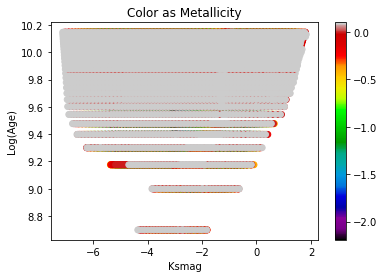

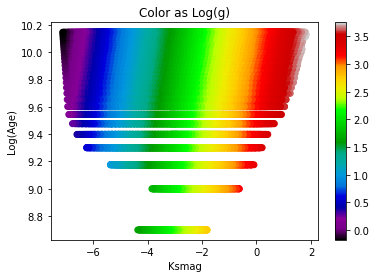

----------


In [5]:
pcol = ['Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0',
        'period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z',
        'mbolmag','Jmag','Hmag','Ksmag']

for i in range(len(pcol)):
    plt.figure()
    plt.scatter(parsec[pcol[i]],parsec['logAge'],c=parsec['MH'],cmap='nipy_spectral')
    plt.colorbar()
    plt.title(r'Color as Metallicity')
    plt.ylabel(r'Log(Age)')
    plt.xlabel(r'{}'.format(pcol[i]))
    plt.show()

    plt.figure()
    plt.scatter(parsec[pcol[i]],parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
    plt.colorbar()
    plt.title(r'Color as Log(g)')
    plt.ylabel(r'Log(Age)')
    plt.xlabel(r'{}'.format(pcol[i]))
    plt.show()
    
    print('----------')

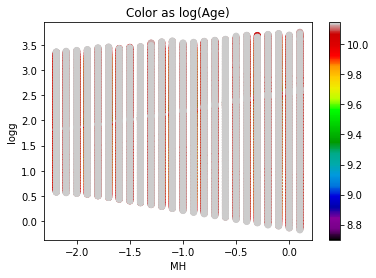

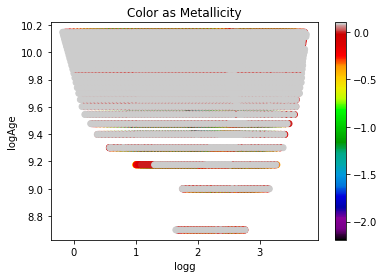

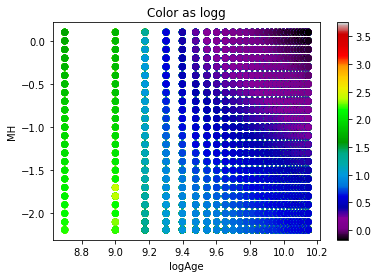

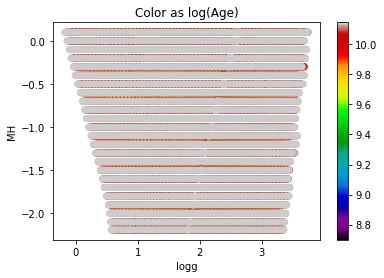

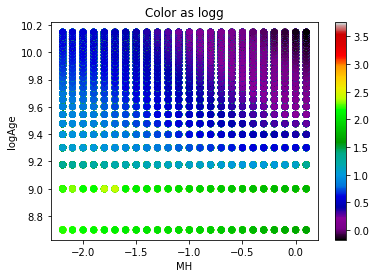

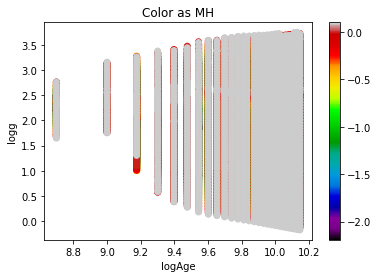

In [6]:
plt.figure()
plt.scatter(parsec['MH'],parsec['logg'],c=parsec['logAge'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as log(Age)')
plt.ylabel(r'logg')
plt.xlabel(r'MH')
plt.show()

plt.figure()
plt.scatter(parsec['logg'],parsec['logAge'],c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Metallicity')
plt.ylabel(r'logAge')
plt.xlabel(r'logg')
plt.show()
           
plt.figure()
plt.scatter(parsec['logAge'],parsec['MH'],c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as logg')
plt.ylabel(r'MH')
plt.xlabel(r'logAge')
plt.show()
           
plt.figure()
plt.scatter(parsec['logg'],parsec['MH'],c=parsec['logAge'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as log(Age)')
plt.ylabel(r'MH')
plt.xlabel(r'logg')
plt.show()
           
plt.figure()
plt.scatter(parsec['MH'],parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as logg')
plt.ylabel(r'logAge')
plt.xlabel(r'MH')
plt.show()
           
plt.figure()
plt.scatter(parsec['logAge'],parsec['logg'],c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as MH')
plt.ylabel(r'logg')
plt.xlabel(r'logAge')
plt.show()

In [7]:
# [Fe/H], Teff, Ksmag, logg

In [8]:
###############################
### Get Solar X_M Fractions ###
###############################

# Asplund 2009 solar Abundances
abund_dict = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
abund = np.asarray([8.39,7.78,8.66,7.53,6.31,7.14,7.51,7.45])

X_H_sol = []
for i in abund:
    X_H_sol.append(i-12.0)
    
X_M_sol = 10**np.asarray(X_H_sol)/sum(10**np.asarray(X_H_sol))

(array([  10.,   10.,   55., 7409., 4644., 6189., 6386., 7010., 7425.,
        7778.]),
 array([-3.73683754, -3.36649268, -2.99614783, -2.62580298, -2.25545813,
        -1.88511327, -1.51476842, -1.14442357, -0.77407872, -0.40373387,
        -0.03338901]),
 <BarContainer object of 10 artists>)

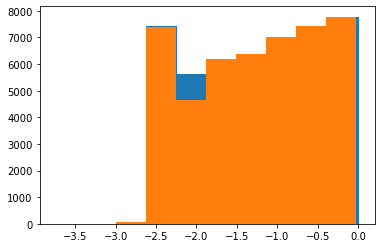

In [12]:
plt.hist(np.log10(parsec['Z']/0.019)-np.log10(parsec['X']/0.708))
plt.hist(np.log10(parsec['Z']/0.02))

In [10]:
X_H_sol[0]

-3.6099999999999994

In [13]:
from photutils.utils import ShepardIDWInterpolator as idw

In [19]:
parsec_arr = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Z']/0.02),parsec['logg']]).T
inter = idw(parsec_arr,parsec['logAge'])

In [35]:
test_age = []

for i in range(len(lmc)):
    _, _, dist_test = afunc.LMCdisk_cart(lmc['RA'][i],lmc['DEC'][i])
    absK_test = afunc.absmag(lmc['K'][i],dist_test) - lmc['AK_TARG'][i]

    feh_test = afunc.sal(lmc['M_H'][i],lmc['ALPHA_M'][i])

    test_age.append(inter(np.array([np.log10(lmc['TEFF'][i]),absK_test,feh_test,lmc['LOGG'][i]])))

(array([165., 593., 182., 188., 151., 122., 175., 112., 297., 603.]),
 array([ 0.5       ,  1.81857988,  3.13715976,  4.45573964,  5.77431952,
         7.09289941,  8.41147929,  9.73005917, 11.04863905, 12.36721893,
        13.68579882]),
 <BarContainer object of 10 artists>)

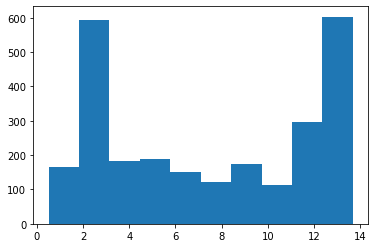

In [37]:
plt.hist(10**np.asarray(test_age)/10**9)

In [39]:
### Bloop Cut
kmags = [0.7,1.]
colos = [13.5,12.]

zbloop = np.polyfit(kmags, colos, 1)
pbloop = np.poly1d(zbloop)

bloop_cut = np.where(lmc['K']>pbloop(lmc['J']-lmc['K'])+0.1)

lmc_nobloop = lmc[bloop_cut]

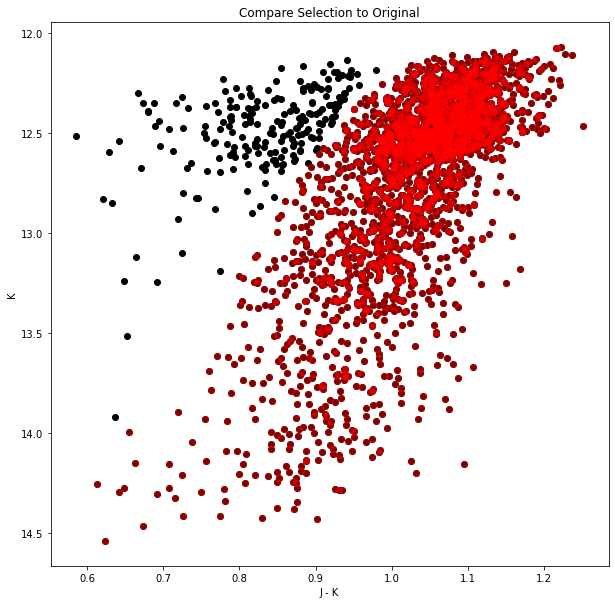

In [41]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.scatter((lmc_nobloop['J']-lmc_nobloop['K']),lmc_nobloop['K'],c='r',alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Compare Selection to Original')

plt.show()

(array([153., 418., 179., 186., 151., 122., 172., 109., 295., 592.]),
 array([ 0.5       ,  1.81857988,  3.13715976,  4.45573964,  5.77431952,
         7.09289941,  8.41147929,  9.73005917, 11.04863905, 12.36721893,
        13.68579882]),
 <BarContainer object of 10 artists>)

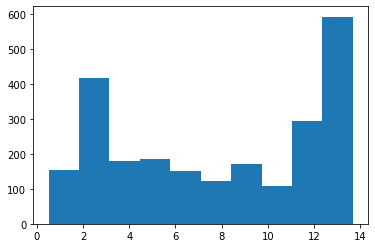

In [44]:
plt.hist(10**np.asarray(test_age)[bloop_cut]/10**9)

In [42]:
len(lmc)-len(lmc_nobloop)

211

In [50]:
# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, lmc_ind, pdfout_ind = np.intersect1d(lmc_nobloop['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

Text(0, 0.5, 'Bayesian')

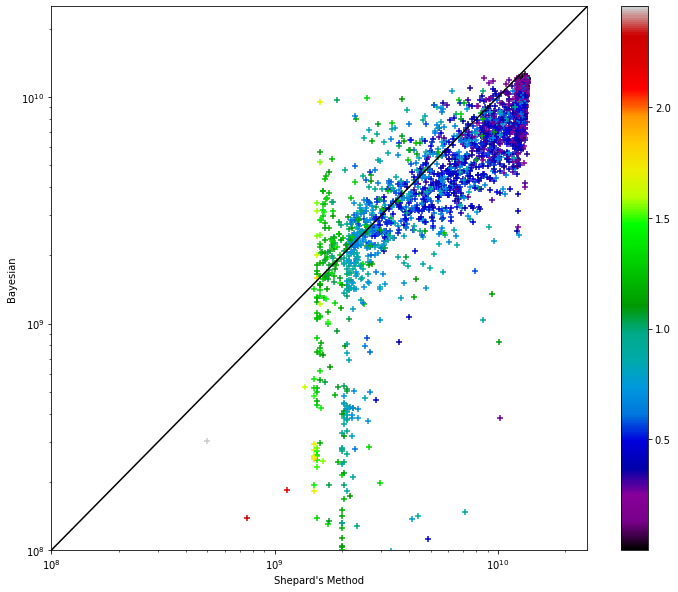

In [62]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(test_age)[bloop_cut][lmc_ind],10**pdfout['P_MEAN'][pdfout_ind],
            c=lmc_nobloop['LOGG'][lmc_ind],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**8,10**10.4)
plt.xlim(10**8,10**10.4)

plt.xlabel(r'''Shepard's Method''')
plt.ylabel(r'Bayesian')

In [18]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

(46916, 4)

In [ ]:
age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))